In [158]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

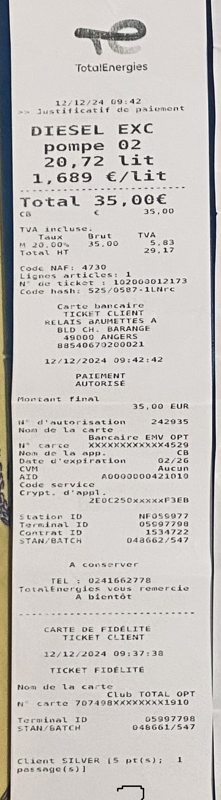

In [159]:
# Sample file out of the dataset
file_name = r'C:\Users\gilles\project02\data project 05\Receipt02.png'
img = Image.open(file_name)
img.thumbnail((800, 800))
img

In [160]:
#  resize image using OpenCV while maintaining the original aspect ratio.
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)  # Compute new width
    height = int(image.shape[0] * ratio)  # Compute new height
    dim = (width, height)  # Create (width, height) tuple
    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)  # Resize the image

In [161]:
# to display an image with the correct color format
def plot_rgb(image):
    plt.figure(figsize=(16, 10))  # Create a new figure with a larger size
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert and display the image


In [162]:
# display an image in grayscale using Matplotlib
def plot_gray(image):
    plt.figure(figsize=(16, 10))  # Create a new figure with a larger size
    return plt.imshow(image, cmap='Greys_r')  # Display the image in grayscale


In [163]:
image = cv2.imread(r'C:\Users\gilles\project02\data project 05\Receipt02.png')
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

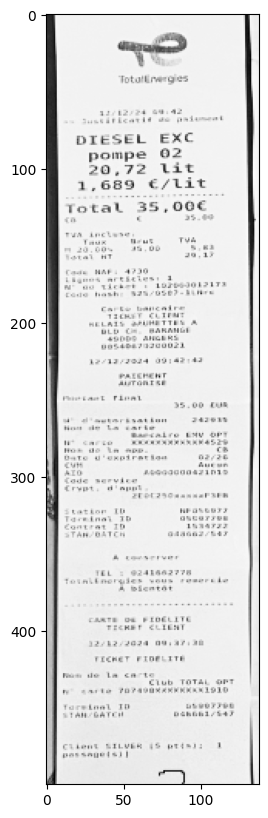

In [164]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

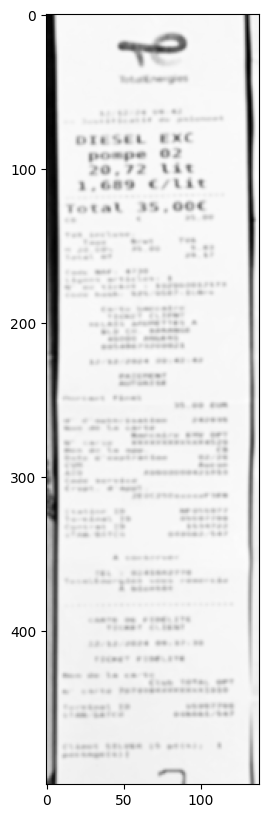

In [165]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

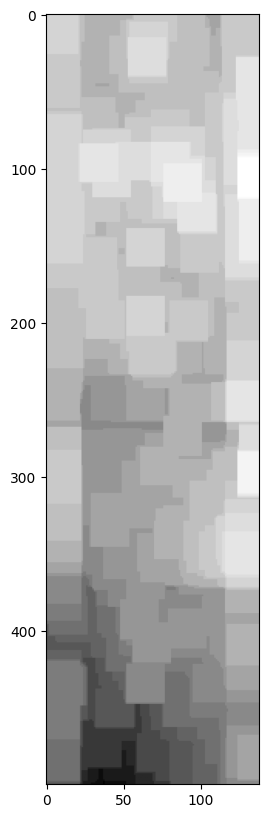

In [166]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

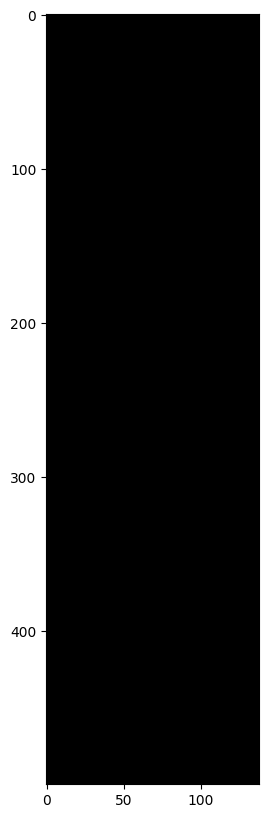

In [167]:
# detects the edges in an image by looking for areas of rapid intensity change
edged = cv2.Canny(dilated, 10, 100)  # Reduce upper/lower thresholds
plot_gray(edged)

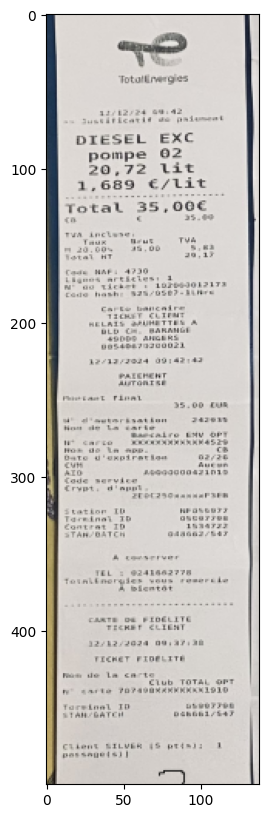

In [168]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

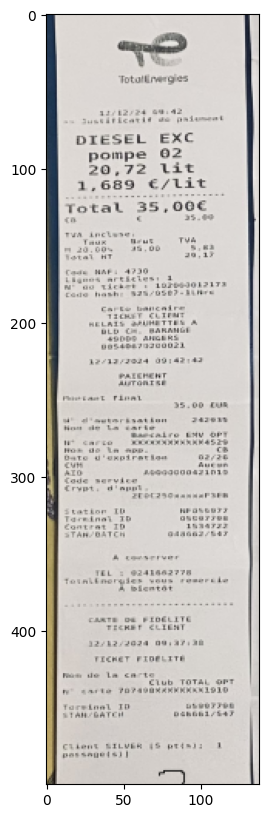

In [169]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [170]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [171]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [172]:
get_receipt_contour(largest_contours)

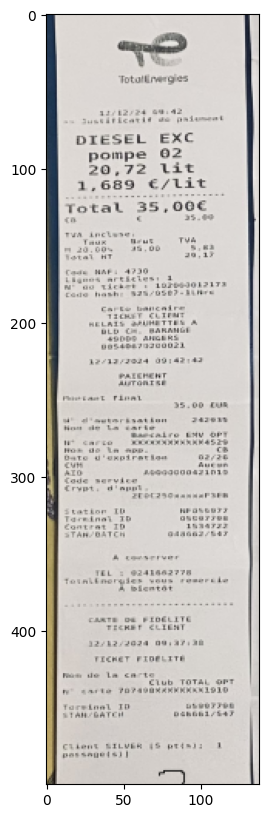

In [173]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [174]:
receipt_contour = None

for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.05 * cv2.arcLength(contour, True), True)  # Adjusted from 0.02 to 0.05
    
    if len(approx) == 4:  # Keep only 4-point contours
        area = cv2.contourArea(approx)
        if area > 10000:  # Ignore very small contours (Adjust this threshold if needed)
            receipt_contour = approx
            break  # Stop at the first good one

if receipt_contour is None:
    print("Error: No valid receipt contour found!")


Error: No valid receipt contour found!


Step 2: Cropping and perspective restoration

use of cv2.warpPerspective to restore perspective of the receipt. We have to do some preparations though:

convert contour into a rectangle-like coordinate array consisting of clockwise ordered points: top-left, top-right, bottom-right, bottom-left
use rectangle points to calculate destination points of the "scanned" view
feed destination points into cv2.getPerspectiveTransform to calculate transformation matrix
and finally use cv2.warpPerspective to restore the perspective!

In [175]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [176]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

In [177]:
print(receipt_contour)  # Check if it's None or contains valid contours


None


In [178]:

edged = cv2.Canny(dilated, 50, 150)  # Reduce upper/lower thresholds

In [179]:
print(f"Number of contours found: {len(contours)}")
for i, contour in enumerate(contours[:5]):  # Check first 5 contours
    print(f"Contour {i+1}: Approx size = {len(cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True))}")


Number of contours found: 0


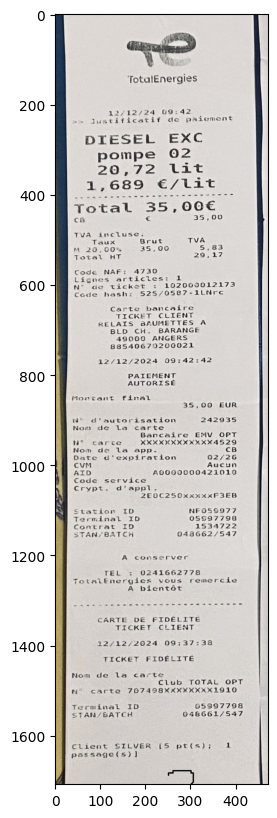

In [180]:
contour_img = original.copy()
cv2.drawContours(contour_img, contours, -1, (0, 300, 0), 2)
plot_rgb(contour_img)


In [181]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

AttributeError: 'NoneType' object has no attribute 'reshape'